1. Importamos los datos del archivo “Tiempo de entrega.csv” a nuestro entorno de trabajo y generamos una gráfica de dispersión para visualizar su comportamiento. Al revisar los datos, detectamos valores que no se podían usar para la regresión, como respuestas no numéricas, filas vacías, tiempos negativos y tiempos extremadamente altos. Decidimos eliminar estas observaciones, ya que no aportan información útil para el análisis y podrían afectar la precisión del modelo de regresión.

Tamaño inicial: (443, 2)
Tamaño después de limpiar Calificacion y Tiempo: (373, 2)


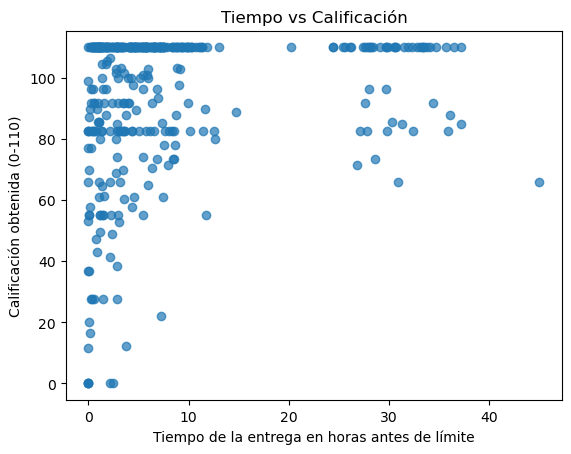

In [2]:
import pandas as pd #Importamos pandas
import numpy as np #Importamos numpy
import matplotlib.pyplot as plt #Importamos matplotlib
datos = pd.read_csv("A1.6 Tiempo de Entrega.csv") #Importamos los datos
print("Tamaño inicial:", datos.shape) #Revisamos el tamaño inicial del DataFrame
datos["Calificacion"] = pd.to_numeric(datos["Calificacion"], errors="coerce") #Convertimos Calificacion a numérico; los datos no numéricos se convierten en NaN
datos = datos.dropna(subset=["Calificacion"]) #Eliminamos filas con NaN en Calificacion
#Eliminar outliers de Tiempo usando Tukey (3*IQR)
q1 = datos.Tiempo.quantile(0.25) #Percentil 25 de Tiempo
q3 = datos.Tiempo.quantile(0.75) #Percentil 75 de Tiempo
li = q1 - 3*(q3 - q1) #Límite inferior según Tukey
ls = q3 + 3*(q3 - q1) #Límite superior según Tukey
out=np.where((datos.Tiempo<=li) | (datos.Tiempo>=ls))[0] #Encontramos los datos que están fuera del rango
datos=datos.drop(out) #Quitamos los datos fuera de rango
print("Tamaño después de limpiar Calificacion y Tiempo:", datos.shape) #Revisamos tamaño tras limpiar
%matplotlib inline 
plt.scatter(datos.Tiempo, datos.Calificacion, alpha=0.7) #Graficamos Tiempo vs Calificacion
plt.xlabel("Tiempo de la entrega en horas antes de límite") #Etiqueta eje X
plt.ylabel("Calificación obtenida (0-110)") #Etiqueta eje Y
plt.title("Tiempo vs Calificación") #Título de la gráfica
plt.show() #Mostramos la gráfica

Para resolver la tarea, utilizaré regresión NO lineal, ya que no vemos que se siga esa tendencia. 

2. Separamos los datos en entrenamiento y prueba, con una relación de 70/30. Imprimimos en consola el promedio de los tiempos en el conjunto de entrenamiento y en el conjunto de prueba. Hacemos lo mismo para las calificaciones. 

In [3]:
train=datos.sample(frac=.7, random_state=42) #Escogemos los datos de entrenamiento que sean un 70%
test = datos.drop(train.index) #Drop o soltamos los datos previamente escogidos para el entrenamiento
x_train=train.Tiempo
x_test=test.Tiempo
y_train=train.Calificacion
y_test=test.Calificacion
mean_train_t=train.Tiempo.mean()
mean_train_c=train.Calificacion.mean()
mean_test_t=test.Tiempo.mean()
mean_test_c=test.Calificacion.mean()
print("Promedio de entrenamiento- Tiempo: ", mean_train_t)
print("Promedio de prueba- Tiempo: ", mean_test_t)
print("Promedio de entrenamiento- Calificacion: ", mean_train_c)
print("Promedio de prueba- Calificacion: ", mean_test_c)

Promedio de entrenamiento- Tiempo:  8.320127713885057
Promedio de prueba- Tiempo:  6.759191468401786
Promedio de entrenamiento- Calificacion:  93.26504302681991
Promedio de prueba- Calificacion:  94.46741508928572


Los datos de calificación tienen un promedio similar, con una diferencia de 1.2, y los de horas una diferencia de 1.6, creo que la diferencia en horas puede tener un poco más de efecto en la calidad de nuestro modelo porque en escala, si es una amyor diferencia en los promedios. 

3. Entrenamos un modelo de regresión polinomial usando los datos de entrenamiento. Utilizaré un modelo orden 4, ya que es el que mejor R2 me genera sin caer en el sobreajuste. 

In [4]:
Xtemp_train = x_train.array.reshape(-1,1) #convertimos los datos de entrenamiento a formato columna
Xtemp_test = x_test.array.reshape(-1,1) #convertimos los datos de prueba a formato columna
from sklearn.preprocessing import PolynomialFeatures #importamos la clase para generar polinomios
import statsmodels.api as sm #importamos statsmodels para la regresion
polyq = PolynomialFeatures(degree=4) #creamos el generador de polinomios de grado 4
Xq_train = pd.DataFrame(polyq.fit_transform(Xtemp_train)) #transformamos los datos de entrenamiento
Xq_test = pd.DataFrame(polyq.transform(Xtemp_test)) #transformamos los datos de prueba
mq = sm.OLS(list(y_train), Xq_train).fit() #ajustamos el modelo de regresion polinomial grado 4
print(mq.summary()) #mostramos el resumen del modelo
Xq_test = pd.DataFrame(polyq.transform(Xtemp_test)) #transforma a forma deseada
y_hat_mq = mq.predict(Xq_test) #Predecimos valores 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     11.95
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           6.46e-09
Time:                        18:08:01   Log-Likelihood:                -1182.3
No. Observations:                 261   AIC:                             2375.
Df Residuals:                     256   BIC:                             2392.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             74.1345      3.215     23.062      0.0

El factor lineal es positivo (8.1714) y su p si es menor a 0.05, entonces se podría decir que por cada hora antes que entregues la tarea, tendrás 8.1714 puntos más en la calificación con un 95% de confianza. Esto es hablando estrictamente del coeficiente lineal.  También vemos que la R2 es de 0.157

4. Entrenamos un modelo de regresión segmentada, utilizando regresiones cuadráticas para cada segmento. Generamos estimaciones en los datos de validación

In [7]:
from mlinsights.mlmodel import PiecewiseRegressor
ms = PiecewiseRegressor('bins').fit(Xq_train.iloc[:,1:],y_train)
y_hat_ms = ms.predict(Xq_test.iloc[:,1:])
y_mean = np.mean(y_test)
TSS = sum((y_test - y_mean)**2)
RSS = sum((y_test - y_hat_ms)**2)
r2_manual_ms = 1 - RSS/TSS
print("R² modelo segmentado:", r2_manual_ms)

R² modelo segmentado (manual): 0.10911550467436515


5. Entrenamos un modelo KNN para regresión utilizando el valor de k que consideramos adecuado. Generamos 
estimaciones en los datos de prueba. Probando con varios valores de k, encontré que 10 me generaba el menor RSE

In [8]:
from sklearn.neighbors import KNeighborsRegressor as KNN
mk = KNN(n_neighbors=10).fit(Xtemp_train,y_train)
y_hat_mk = mk.predict(Xtemp_test)
RSS_mk = sum((list(y_test)-y_hat_mk)**2)
RSE_mk = np.sqrt(RSS_mk/(len(y_test)-1))
print("RSE modelo KNN ", RSE_mk)
TSS = sum((y_test - y_mean)**2)
RSS = sum((y_test - y_hat_mk)**2)
r2_manual = 1 - RSS/TSS
print("R² modelo KNN:", r2_manual)

RSE modelo KNN  23.365461040736523
R² modelo KNN: 0.13463715858668346


6. Calculamos el RSE en los datos de prueba para los 3 modelos.

In [14]:
RSS_mq = sum((list(y_test)-y_hat_mq)**2)
RSE_mq = np.sqrt(RSS_mq/(len(y_test)-1))
print("RSE modelo orden 4: ", RSE_mq)
RSS_ms = sum((list(y_test)-y_hat_ms)**2)
RSE_ms = np.sqrt(RSS_ms/(len(y_test)-1))
print("RSE modelo segmentado ", RSE_ms)
print("RSE modelo KNN ", RSE_mk)


RSE modelo orden 4:  24.048123451679974
RSE modelo segmentado  23.707509529864986
RSE modelo KNN  23.365461040736523


El menor RSE es el modelo KNN, más no diría que es un claro ganador, ya que el RSE es cercano a los otros dos modelos, que tienen una mucho mayor intepretabilidad, por lo que no diría que hay un ganador absoluto entre el modelo de orden 4 o el segmentado. 

7. Graficamos tanto las calificaciones reales como las predichas porlos 3 modelos en un mismo plot. 

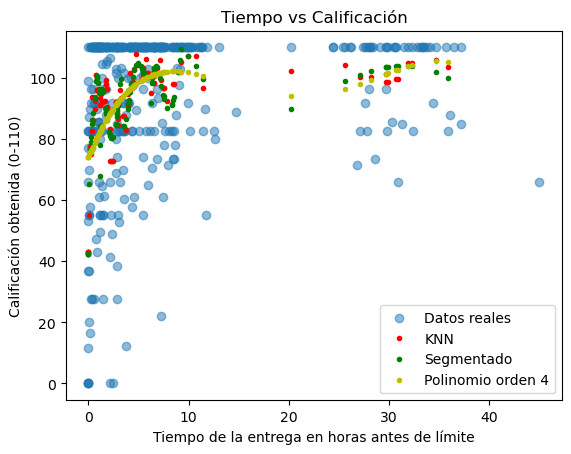

In [7]:
plt.scatter(datos.Tiempo, datos.Calificacion, alpha=0.5, label="Datos reales")  #Graficamos Tiempo vs Calificación
plt.xlabel("Tiempo de la entrega en horas antes de límite")  #Etiqueta eje X
plt.ylabel("Calificación obtenida (0-110)")  #Etiqueta eje Y
plt.title("Tiempo vs Calificación")  #Título de la gráfica
plt.plot(x_test, y_hat_mk, "r.", label="KNN")  # Rojo
plt.plot(x_test, y_hat_ms, "g.", label="Segmentado")  # Verde
plt.plot(x_test, y_hat_mq, "y.", label="Polinomio orden 4")  # Amarillo
plt.legend()  # Agrega la leyenda
plt.show()  #Mostramos la gráfica

En conclusión, al analizar la gráfica comparativa, se observa que ninguno de los modelos de regresión aplicados logra ajustarse de manera adecuada a los datos reales. Esto sugiere que la relación planteada en la hipótesis inicial no se cumple necesariamente, por lo que sería necesario reconsiderar el modelo propuesto o explorar variables adicionales que puedan explicar de mejor manera el comportamiento de los datos.